<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<hr>

# CAMS global atmospheric composition forecasts - Particulate matter d < 2.5 µm (PM2.5)

### About

This notebook provides an introduction to the [CAMS global atmospheric composition forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview) and shows you how the variable `Particulate matter d < 2.5 µm (PM2.5)` can be used to monitor air quality.

CAMS produces global forecasts for atmospheric composition for the next five days twice a day. The forecasts consist of more than 50 chemical species (e.g. ozone, nitrogen dioxide, carbon dioxide) and seven different types of aerosol (desert dust, sea salt, organic matter, black carbon, sulphate, nitrate and ammonium aerosol).

The initial conditions of each forecast are obtained by combining a previous forecast with current satellite observations through a process called data assimilation. This best estimate of the state of the atmosphere at the initial forecast time step, called the analysis, provides a globally complete and consistent dataset allowing for estimates at locations where observation data coverage is low or for atmospheric pollutants for which no direct observations are available.

### Basic Facts

> **Spatial resolution**: `0.4° x 0.4°` <br>
> **Spatial coverage**: `Global` <br>
> **Temporal resolution**:  `1-hourly up to leadtime hour 120` <br>
> **Temporal coverage**: `since 2015 to present` <br>
> **Data format**: `GRIB` or `zipped NetCDF`


### How to access the data

CAMS global atmospheric composition forecasts are available for download via the [Copernicus Atmosphere Data Store (ADS)](https://ads.atmosphere.copernicus.eu/). You will need to create an ADS account [here](https://ads.atmosphere.copernicus.eu/user/register).

Data from the ADS can be downloaded in two ways:
* `manually` via the [ADS web interface](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview)
* `programmatically` with a Python package called cdsapi ([more information](https://ads.atmosphere.copernicus.eu/api-how-to))

### Module outline
* [*Optional: Retrieve CAMS global atmospheric forecasts programmatically*](#cams_cdsapi_global)
* [1 - Load and browse Particulate matter d < 2.5 µm (PM2.5) of the CAMS global near-real-time forecast](#load_browse_cams_global)
* [2 - Retrieve the data variable PM 2.5 as xarray.DataArray](#data_retrieve_cams_global)
* [3 - Visualize PM 2.5](#visualize_cams_global)
* [4 - Create a geographical subset for Malaysia and part of Indonesia](#subset_cams_global)
* [5 - Animate PM 2.5changes over time](#animate_cams_global)

<hr>

#### Load required libraries

In [25]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [26]:
%run ../functions.ipynb

<hr>

### <a id='cams_cdsapi_global'></a>*Optional: Retrieve CAMS global atmospheric composition forecasts programmatically*

The `CDS Application Program Interface (CDS API)` is a Python library which allows you to access data from the ADS `programmatically`. In order to use the CDS API, follow the steps below:

* [Self-register](https://ads.atmosphere.copernicus.eu/#!/home) at the ADS registration page (if you do not have an account yet)
* [Login](https://ads.atmosphere.copernicus.eu/user/login) to the ADS portal and go to the [api-how-to page](https://ads.atmosphere.copernicus.eu/api-how-to)
* Copy the CDS API key displayed in the black terminal window and replace the `######` of the `KEY` variable below with your individual CDS API key

**Note:** You find your CDS API key displayed in the black terminal box under the section `Install the CDS API key`. If you do not see a URL or key appear in the black terminal box, please refresh your browser tab. 

In [3]:
URL='https://ads.atmosphere.copernicus.eu/api/v2'
KEY='#########################'

<br>

The next step is then to request the data with a so called `API request`. Via the [ADS web interface](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=form), you can select the data and at the end of the web interface, you can open the ADS request via `Show API request`. Copy the request displayed there in the cell below. Once you execute the cell, the download of the data starts automatically.

In [9]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'date': '2020-03-17/2020-03-17',
        'type': 'forecast',
        'format': 'netcdf_zip',
        'variable': 'particulate_matter_2.5um',
        'time': '12:00',
        'leadtime_hour': [
            '0', '12', '15',
            '18', '21', '24',
            '27', '3', '30',
            '33', '36', '39',
            '42', '45', '48',
            '51', '54', '57',
            '6', '60', '63',
            '66', '69', '72',
            '75', '78', '81',
            '84', '87', '9',
            '90',
        ],
    },
    '20200317_cams_pm2p5_forecast.netcdf_zip')

2022-03-23 06:39:20,471 INFO Welcome to the CDS
2022-03-23 06:39:20,473 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2022-03-23 06:39:20,572 INFO Request is completed
2022-03-23 06:39:20,575 INFO Downloading https://download-0002.copernicus-atmosphere.eu/cache-compute-0002/cache/data7/adaptor.mars_constrained.external-1647539808.5491247-29053-12-18dc22e0-494c-41dc-a15a-371e3a14e702.zip to 20200317_cams_pm2p5_forecast.netcdf_zip (24M)
2022-03-23 06:39:22,717 INFO Download rate 11.2M/s  


Result(content_length=25172644,content_type=application/zip,location=https://download-0002.copernicus-atmosphere.eu/cache-compute-0002/cache/data7/adaptor.mars_constrained.external-1647539808.5491247-29053-12-18dc22e0-494c-41dc-a15a-371e3a14e702.zip)

<br>

CAMS global atmospheric composition forecasts can be retrieved either in `GRIB` or in a `zipped NetCDF`. Above, we requested the data in a zipped NetCDF and for this reason, we have to unzip the file before we can open it. You can unzip `zip archives` in Python with the Python package `zipfile` and the function `extractall()`.

In [27]:
import zipfile
with zipfile.ZipFile('./20200317_cams_pm2p5_forecast.netcdf_zip', 'r') as zip_ref:
    zip_ref.extractall('./')

<br>

### <a id='load_browse_cams_global'></a>1. Load and browse CAMS global atmospheric composition forecasts

CAMS global near-real-time forecast data is available either in `GRIB` or `netCDF`. The data for the present example has been downloaded as `netCDF`.

You can use xarray's function `xr.open_dataset()` to open the netCDF file as `xarray.Dataset`.

In [28]:
file = xr.open_dataset('../eodata/cams/forecast/20200317_cams_pm2p5_forecast.nc')
file

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 31)
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2020-03-17T12:00:00 ... 2020-03-21T06:00:00
Data variables:
    pm2p5      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-17 17:56:48 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

<br>

The data above has three dimensions (`latitude`, `longitude`, `time`) and one data variable:
* `pm2p5`: Particulate matter d < 2.5 µm (PM2.5) 

Let us inspect the coordinates of the file more in detail.

Below, you see that the data set consists of 31 time steps, ranging from 17 March 2020 12 UTC to 21 March 2020 06 UTC in a 3-hour timestep.

In [29]:
file.time

<xarray.DataArray 'time' (time: 31)>
array(['2020-03-17T12:00:00.000000000', '2020-03-17T15:00:00.000000000',
       '2020-03-17T18:00:00.000000000', '2020-03-17T21:00:00.000000000',
       '2020-03-18T00:00:00.000000000', '2020-03-18T03:00:00.000000000',
       '2020-03-18T06:00:00.000000000', '2020-03-18T09:00:00.000000000',
       '2020-03-18T12:00:00.000000000', '2020-03-18T15:00:00.000000000',
       '2020-03-18T18:00:00.000000000', '2020-03-18T21:00:00.000000000',
       '2020-03-19T00:00:00.000000000', '2020-03-19T03:00:00.000000000',
       '2020-03-19T06:00:00.000000000', '2020-03-19T09:00:00.000000000',
       '2020-03-19T12:00:00.000000000', '2020-03-19T15:00:00.000000000',
       '2020-03-19T18:00:00.000000000', '2020-03-19T21:00:00.000000000',
       '2020-03-20T00:00:00.000000000', '2020-03-20T03:00:00.000000000',
       '2020-03-20T06:00:00.000000000', '2020-03-20T09:00:00.000000000',
       '2020-03-20T12:00:00.000000000', '2020-03-20T15:00:00.000000000',
       '2020-03-20T18:00:00.000000000', '2020-03-20T21:00:00.000000000',
       '2020-03-21T00:00:00.000000000', '2020-03-21T03:00:00.000000000',
       '2020-03-21T06:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-03-17T12:00:00 ... 2020-03-21T06:00:00
Attributes:
    long_name:  time

The latitude values have a 0.4 degrees resolution and have a global N-S coverage.

In [30]:
file.latitude

<xarray.DataArray 'latitude' (latitude: 451)>
array([ 90. ,  89.6,  89.2, ..., -89.2, -89.6, -90. ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.6 89.2 88.8 ... -88.8 -89.2 -89.6 -90.0
Attributes:
    units:      degrees_north
    long_name:  latitude

The longitude values have a 0.4 degrees resolution as well, and are disseminated in a [0, 360] grid. 

In [31]:
file.longitude

<xarray.DataArray 'longitude' (longitude: 900)>
array([  0. ,   0.4,   0.8, ..., 358.8, 359.2, 359.6], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
Attributes:
    units:      degrees_east
    long_name:  longitude

Above, you see that the `longitude` variables are in the range of `[0, 359.6]`. Per default, ECMWF data are on a [0, 360] grid. Let us bring the longitude coordinates to a `[-180, 180]` grid. You can use the xarray function `assign_coords()` to assign new values to coordinates of a xarray data arra. The code below shifts your longitude coordinates from `[0, 359.6]` to `[-180, 179.6]`.

In [32]:
file = file.assign_coords(longitude=(((file.longitude + 180) % 360) - 180)).sortby('longitude')
file

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 31)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2020-03-17T12:00:00 ... 2020-03-21T06:00:00
Data variables:
    pm2p5      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-17 17:56:48 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

<br>

### <a id='data_retrieve_cams_global'></a>2. Retrieve the variable **Particulate matter d < 2.5 µm (PM2.5)** as data array

Let us extract from the dataset above the data variable `Particulate matter d < 2.5 µm (PM2.5) (AOD) ` as `xarray.DataArray` with the name `pm2p5`. You can load a data array from a xarray dataset by specifying the name of the variable (`pm2p5`) in square brackets.

In [33]:
pm2p5 = file['pm2p5']
pm2p5

<xarray.DataArray 'pm2p5' (time: 31, latitude: 451, longitude: 900)>
[12582900 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2020-03-17T12:00:00 ... 2020-03-21T06:00:00
Attributes:
    units:          kg m**-3
    long_name:      Particulate matter d <= 2.5 um
    standard_name:  mass_concentration_of_pm2p5_ambient_aerosol_particles_in_air

Above, you see that the variable `pm2p5` has two attributes, `units` and `long_name`. Let us define variables for those attributes. The variables can be used later for visualizing the data.

In [34]:
long_name = pm2p5.long_name
units = pm2p5.units

Let us do the same for the coordinates `longitude` and `latitude`.

In [35]:
latitude = pm2p5.latitude
longitude = pm2p5.longitude

<br>

### <a id='visualize_cams_global'></a>3. Visualize **Particulate matter d < 2.5 µm (PM2.5)**

The next step is to visualize the dataset. You can use the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh), which makes use of matplotlib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

With `?visualize_pcolormesh` you can open the function's docstring to see what keyword arguments are needed to prepare your plot.

In [36]:
?visualize_pcolormesh

Signature:
visualize_pcolormesh(
    data_array,
    longitude,
    latitude,
    projection,
    color_scale,
    unit,
    long_name,
    vmin,
    vmax,
    set_global=True,
    lonmin=-180,
    lonmax=180,
    latmin=-90,
    latmax=90,
)
Docstring:
Visualizes a xarray.DataArray with matplotlib's pcolormesh function.

Parameters:
    data_array(xarray.DataArray): xarray.DataArray holding the data values
    longitude(xarray.DataArray): xarray.DataArray holding the longitude values
    latitude(xarray.DataArray): xarray.DataArray holding the latitude values
    projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
    color_scale(str): string taken from matplotlib's color ramp reference
    unit(str): the unit of the parameter, taken from the NetCDF file if possible
    long_name(str): long name of the parameter, taken from the NetCDF file if possible
    vmin(int): minimum number on visualisation legend
    vmax(int): maximum number on visualisation

You can make use of the variables we defined above:
- `units`
- `long_name`
- `latitude`
- `longitude`

Additionally, you can specify the `color scale` and minimum (`vmin`) and maxium (`vmax`) data values. Note: Multiplying the vmin and vmax values with 1e<sup>-8</sup> improves the readibility of the map legend. As vmin is already 0, there is no need to multiply it.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Particulate matter d <= 2.5 um 2020-03-17T15:00'}>)

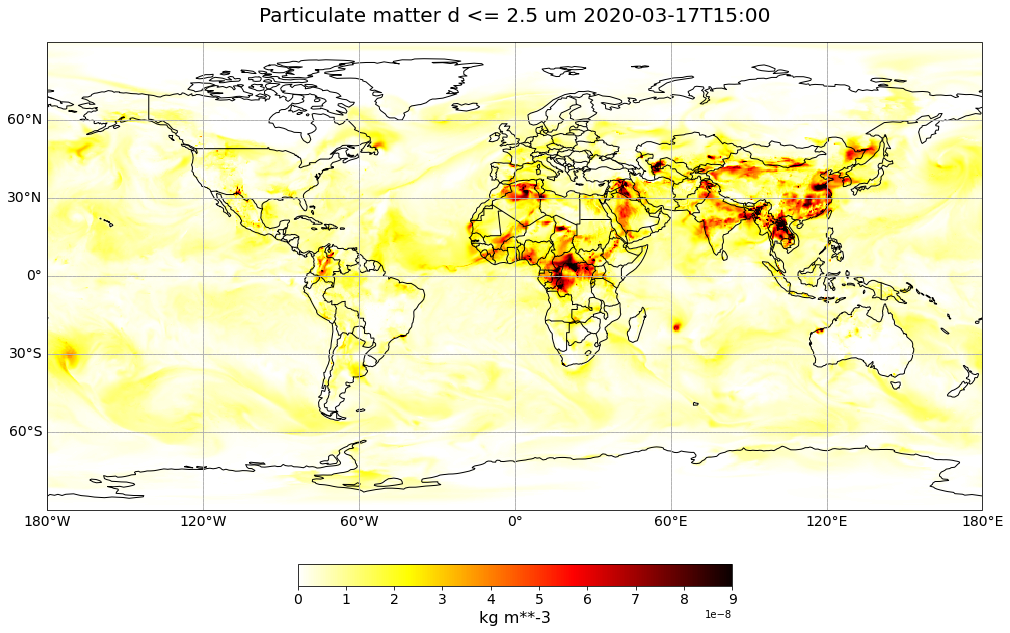

In [38]:
time_index = 1
visualize_pcolormesh(data_array=pm2p5[time_index,:,:],
                     longitude=longitude,
                     latitude=latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='hot_r',
                     unit=units,
                     long_name=long_name + ' ' + str(pm2p5[time_index,:,:].time.data)[0:16],
                     vmin=0, 
                     vmax=9*1e-8)

<br>

### <a id='subset_cams_global'></a>4. Create a geographical subset for part of Southeast Asia

The map above shows Particulate matter d < 2.5 µm (PM2.5) globally. Let us create a geographical subset for Malaysia, Singapore, Brunei and part of Indonesia.

For geographical subsetting, you can use the function [generate_geographical_subset](./functions.ipynb#generate_geographical_subset). You can use `?generate_geographical_subset` to open the docstring in order to see the function's keyword arguments.

In [39]:
?generate_geographical_subset

Signature:
generate_geographical_subset(
    xarray,
    latmin,
    latmax,
    lonmin,
    lonmax,
    reassign=False,
)
Docstring:
Generates a geographical subset of a xarray.DataArray and if kwarg reassign=True, shifts the longitude grid 
from a 0-360 to a -180 to 180 deg grid.

Parameters:
    xarray(xarray.DataArray): a xarray DataArray with latitude and longitude coordinates
    latmin, latmax, lonmin, lonmax(int): lat/lon boundaries of the geographical subset
    reassign(boolean): default is False
    
Returns:
    Geographical subset of a xarray.DataArray.
File:      /tmp/ipykernel_924/3979307327.py
Type:      function


You can zoom into a region by specifying a `bounding box` of interest. Let us set the extent to Malaysia, Brunei, Singapore and part of Indonesia with the following bounding box information:

In [40]:
latmin = -10.
latmax = 10.
lonmin = 95.
lonmax = 120

Now, let us apply the function [generate_geographical_subset](./functions.ipynb#generate_geographcial_subset) to subset the `pm2p5` xarray.DataArray. Let us call the new `xarray.DataArray` `pm2p5_subset`.

In [41]:
pm2p5_subset = generate_geographical_subset(xarray=pm2p5, 
                                             latmin=latmin, 
                                             latmax=latmax, 
                                             lonmin=lonmin, 
                                             lonmax=lonmax)
pm2p5_subset

<xarray.DataArray 'pm2p5' (time: 31, latitude: 49, longitude: 62)>
array([[[7.63554908e-09, 6.49833964e-09, 5.80786264e-09, ...,
         4.99557018e-09, 4.77217554e-09, 4.46760851e-09],
        [9.44288558e-09, 7.87923682e-09, 6.37646735e-09, ...,
         5.76727643e-09, 5.23925792e-09, 4.71129624e-09],
        [9.60534408e-09, 8.08228151e-09, 6.68109124e-09, ...,
         6.15307272e-09, 5.60481794e-09, 5.05650632e-09],
        ...,
        [2.88360980e-09, 3.04606829e-09, 3.06636139e-09, ...,
         1.08643690e-08, 2.58714863e-08, 9.32309376e-08],
        [2.82267365e-09, 2.94454594e-09, 3.04606829e-09, ...,
         1.80328925e-08, 3.29587806e-08, 4.14675583e-08],
        [2.72115130e-09, 2.84302359e-09, 3.04606829e-09, ...,
         1.09050120e-08, 1.70377916e-08, 1.23264954e-08]],

       [[6.35617425e-09, 5.74692649e-09, 5.86879878e-09, ...,
         3.87865384e-09, 4.10204848e-09, 4.65036010e-09],
        [8.20415380e-09, 6.96536517e-09, 6.19371576e-09, ...,
         4.85340479e-09, 4.60971705e-09, 4.65036010e-09],
        [9.11796860e-09, 7.73707143e-09, 6.51863274e-09, ...,
         5.11744247e-09, 4.79252549e-09, 4.65036010e-09],
...
        [1.92915195e-09, 1.88856575e-09, 1.68546421e-09, ...,
         2.31706281e-08, 2.52622954e-08, 3.41162831e-08],
        [2.15254659e-09, 2.05102424e-09, 2.05102424e-09, ...,
         1.94543759e-08, 6.96536517e-09, 2.82267365e-09],
        [2.45717047e-09, 2.31500508e-09, 2.25406893e-09, ...,
         2.04900630e-08, 1.42963472e-08, 6.76232048e-09]],

       [[1.66316454e-08, 1.49055381e-08, 1.19406991e-08, ...,
         1.03364073e-08, 1.05800950e-08, 7.73707143e-09],
        [1.51695190e-08, 1.35246410e-08, 1.13517444e-08, ...,
         8.26503310e-09, 6.78261358e-09, 5.76727643e-09],
        [1.31794309e-08, 1.24686608e-08, 1.14736167e-08, ...,
         6.51863274e-09, 5.88909188e-09, 5.48294565e-09],
        ...,
        [1.52300572e-09, 1.50271262e-09, 1.46212642e-09, ...,
         1.52710982e-08, 2.14851070e-08, 8.14323471e-08],
        [1.86827265e-09, 1.82762960e-09, 1.80733650e-09, ...,
         1.17578907e-08, 3.73654530e-09, 2.68056510e-09],
        [2.23377583e-09, 2.15254659e-09, 2.15254659e-09, ...,
         1.48852450e-08, 8.83363782e-09, 6.31553121e-09]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 95.2 95.6 96.0 96.4 ... 118.8 119.2 119.6
  * latitude   (latitude) float32 9.6 9.2 8.8 8.4 8.0 ... -8.4 -8.8 -9.2 -9.6
  * time       (time) datetime64[ns] 2020-03-17T12:00:00 ... 2020-03-21T06:00:00
Attributes:
    units:          kg m**-3
    long_name:      Particulate matter d <= 2.5 um
    standard_name:  mass_concentration_of_pm2p5_ambient_aerosol_particles_in_air

Let us visualize the subsetted `xarray.DataArray` again. This time, you set the `set_global` kwarg to `False` and you specify the longitude and latitude bounds specified above.

Additionally, in order to have the time information as part of the title, we add the string of the datetime information to the `long_name` variable: `long_name + ' ' + str(pm2p5_subset[##,:,:].time.data)`. Multiplying the vmin and vmax values with 1e<sup>-8</sup> improves the readibility of the map legend. As vmin is already 0, there is no need to multiply it.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Particulate matter d <= 2.5 um 2020-03-19T18:00'}>)

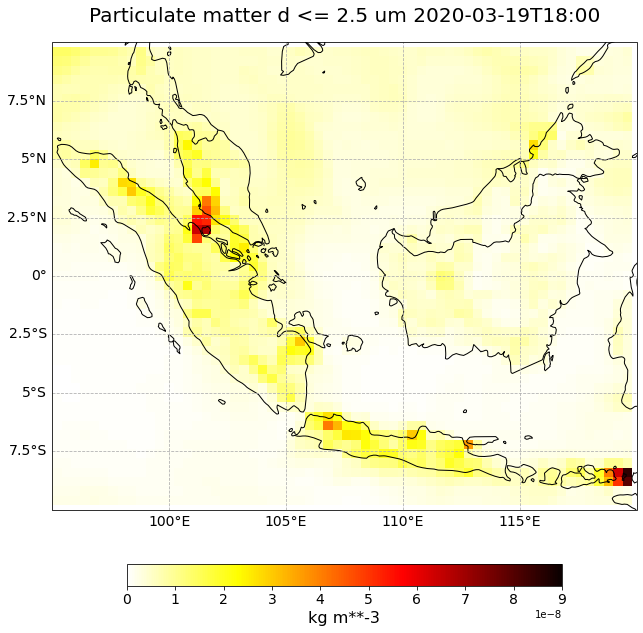

In [44]:
time_index = 18
visualize_pcolormesh(data_array=pm2p5_subset[time_index,:,:],
                     longitude=pm2p5_subset.longitude,
                     latitude=pm2p5_subset.latitude,
                     projection=ccrs.PlateCarree(),
                     color_scale='hot_r',
                     unit=units,
                     long_name=long_name + ' ' + str(pm2p5_subset[time_index,:,:].time.data)[0:16],
                     vmin=0, 
                     vmax=9*1e-8,
                     lonmin=lonmin,
                     lonmax=lonmax,
                     latmin=latmin,
                     latmax=latmax,
                     set_global=False)

<br>

### <a id='animate_cams_global'></a>5. Animate changes of *Particulate matter d < 2.5 µm (PM2.5) * over time

In the last step, you can animate the `Particulate matter d < 2.5 µm (PM2.5) ` in order to see how the trace gas develops over a period of 5 days, from 17th March 2020 to 21st March 2020.

You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [45]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=pm2p5_subset[0,:,:],
                               longitude=pm2p5_subset.longitude, 
                               latitude=pm2p5_subset.latitude,
                               projection=ccrs.PlateCarree(), 
                               color_scale='hot_r', 
                               unit=units,
                               long_name=long_name + ' '+ str(pm2p5_subset.time[0].data)[0:16],
                               vmin=0,
                               vmax=9*1e-8, 
                               lonmin=lonmin, 
                               lonmax=lonmax, 
                               latmin=latmin, 
                               latmax=latmax,
                               set_global=False)

frames = 30

def draw(i):
    img = plt.pcolormesh(pm2p5_subset.longitude, 
                         pm2p5_subset.latitude, 
                         pm2p5_subset[i,:,:], 
                         cmap='hot_r', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=9*1e-8,
                         shading='auto')
    
    ax.set_title(long_name + ' '+ str(pm2p5_subset.time[i].data)[0:16], fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)

2022-03-23 08:28:52,165 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-03-23 08:28:52,168 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1440x720 -pix_fmt rgba -r 1.25 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpqp88907p/temp.m4v


<br>

#### Play the animation video as HTML5 video

In [46]:
HTML(ani.to_html5_video())

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>